# Group members: 
# 1 - Mohammad Kachmar    
# 2 - Serge Ohannessian

# A. Data import
### 1. Import the dataset into a DataFrame.

In [1]:
import pandas as pd
df = pd.read_csv("adult.csv")

### 2. In a pie chart, display the class distribution (percentage of people in the dataset with
### income <=50 K versus income>50K)

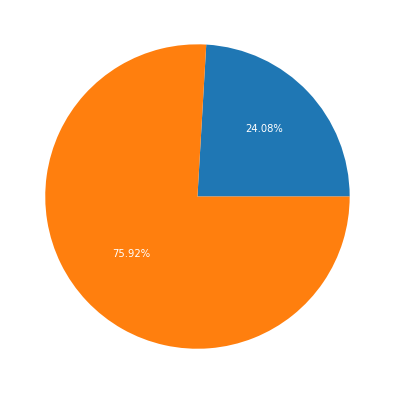

In [2]:

# Import libraries
import numpy as np
import matplotlib.pyplot as plt


 
data = [sum(df['Income'] == ' >50K'), sum(df['Income'] == ' <=50K')]
labels = ['>50K', '<=50K']
 
def func(value, allvalues):
    absolute = int(value / 100.*np.sum(allvalues))
    return "{:.2f}%\n".format(value, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
ax.pie(data, autopct = lambda value: func(value, data), labels = labels, textprops = dict(color ="white"))
 
plt.show()

### 3. Check whether we have missing values. What is the percentage of rows with missing
### data?

In [3]:
columns = ['Age','Workclass','fnlwgt','Education','Education Number','Marital Status','Occupation','Relationship','Race','Gender','Capital Gain','Capital Loss','Hours per week','Native Country','Income']
for column in columns:
    df.loc[df[column] == " ?", column] = None
missingDataRows = sum(df.isna().any(axis=1)) # check if ' ?' null value exists in any of the columns (axis 1)
print("{:.2f}%".format(missingDataRows/len(df['Income']) * 100))



7.37%


# B. Data preprocessing (3 pts)
### 1. For each feature, replace missing values with the mode (categorical features) or the
### mean (numerical features).

In [4]:
columns_with_nans = []
for i in columns:
    if not df[df.isna()[i]].empty :   #check if columns has nan values
        columns_with_nans.append(i)   # append the column if so

replacement_values = df.mode()[columns_with_nans]   #store the modes of those columns in another df
for i in range(len(columns_with_nans)):
    df[columns_with_nans[i]] = df[columns_with_nans[i]].fillna(replacement_values[columns_with_nans[i]][0])  #for each column replace the nan with the mode of that column



### 2. Plot a box plot for each numerical feature by splitting on the label (<=50K and >50K).
### Can you spot any outliers?


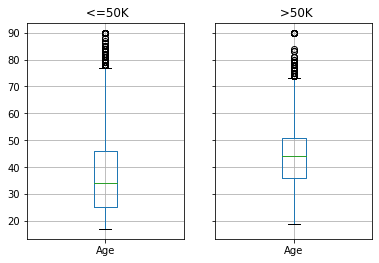

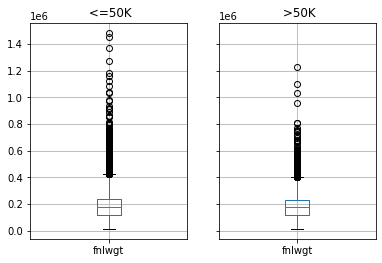

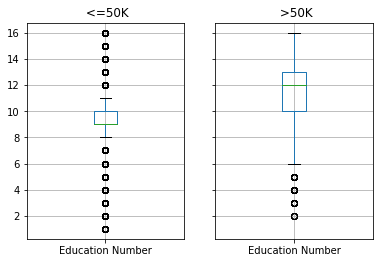

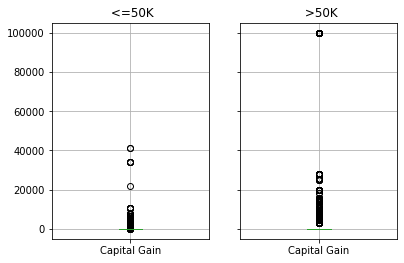

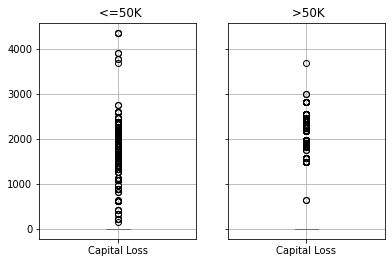

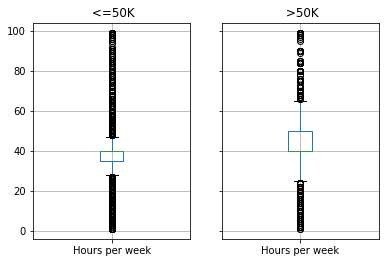

In [5]:
numerical_columns = (df.select_dtypes(include=np.number).columns.tolist())
for i in numerical_columns:
    df.groupby('Income').boxplot(column=i)
    plt.show()

### 3. Normalize numerical features. State which normalization method you chose.


In [6]:
print(df.var())
df[numerical_columns] = np.log(df[numerical_columns]+1)   #using log normalization and adding a constant to handle 0's 
print(df.var())

Age                 1.860614e+02
fnlwgt              1.114080e+10
Education Number    6.618890e+00
Capital Gain        5.454254e+07
Capital Loss        1.623769e+05
Hours per week      1.524590e+02
dtype: float64
Age                 0.122522
fnlwgt              0.397830
Education Number    0.074975
Capital Gain        6.025737
Capital Loss        2.510897
Hours per week      0.149780
dtype: float64


### 4. Split your dataset into 80% training and 20% testing.


### 5. Transform categorical data into numerical using one-hot encoding.

### 6. Use LabelEncoder from sklearn.preprocessing to deal with the non-numerical
### output. 

In [7]:
from sklearn.model_selection import train_test_split

X = df[columns[:-1]]
y = df["Income"]

#5. Transform categorical data into numerical using one-hot encoding.
X = pd.get_dummies(X)


# 6. Use LabelEncoder from sklearn.preprocessing to deal with the non-numerical output. 
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y = LE.fit_transform(y)

# 4. Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,stratify=y)

# C. Modeling – Shallow Models (8 pts)
### 1. Decision tree
#### a. Split the 80% of your data into training and validation (choice of split percentage is left to you)

In [8]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train,y_train,test_size= 0.2,stratify=y_train)


#### b. Train a decision tree classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_1,y_train_1)

DecisionTreeClassifier()

#### c. Fine-tune your classifier on different hyperparameters on the validation set


In [10]:
params_rf = {
    'max_depth': [20,40,60,80,100,120],
    'min_samples_leaf': [0.04,0.06,0.08],
    'max_features': [0.2,0.4,0.6,0.8]
}
from sklearn.model_selection import GridSearchCV

grid_dt = GridSearchCV(estimator=dt,param_grid=params_rf,cv=5)
grid_dt.fit(X_test_1,y_test_1)
best_hyperparams = grid_dt.best_params_


#### d. Report the best hyper-parameters and the highest performance on the validation set


In [11]:
print(best_hyperparams)
best_CV_score = grid_dt.best_score_
print(best_CV_score)

{'max_depth': 80, 'max_features': 0.4, 'min_samples_leaf': 0.04}
0.8378119001919385


### 2. Logistic regression
#### a. On the full 80% data, train a linear regression model


In [12]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=1500)
LR.fit(X_train, y_train)


LogisticRegression(max_iter=1500)

#### b. Finetune your model through a 5-fold cross validation

In [13]:
LRparam_grid = {
    'C': [0.001, 0.01, 0.1],
    "fit_intercept": [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
LR_search = GridSearchCV(estimator=LR, param_grid=LRparam_grid, cv=5,)

# fitting the model for grid search 
LR_search.fit(X_test , y_test)
LR_search_score = LR_search.best_score_
LR_search_param = LR_search.best_params_
# summarize
print(LR_search_score)
print(LR_search_param)

# print(lr.get_params())

0.8490683793632325
{'C': 0.1, 'fit_intercept': True, 'solver': 'saga'}


# D. Modeling – Neural Networks (4 pts)
### a. On the full 80% data, for 200 epochs, train a neural network with 5-fold cross validation


In [14]:
from keras.models import Sequential 
from keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


def create_model():
    model = Sequential()
    size = X_train.columns.size
    model.add(Dense(14,input_shape=(size,), activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model,epochs = 200)


from sklearn.model_selection import cross_val_score

kfold = cross_val_score(model, X_train, y_train, cv=5)
kfold.mean()


Epoch 1/200
652/652 [==============================] - 1s 427us/step - loss: 0.5440 - accuracy: 0.7439
Epoch 2/200
652/652 [==============================] - 0s 444us/step - loss: 0.4987 - accuracy: 0.7844
Epoch 3/200
652/652 [==============================] - 0s 429us/step - loss: 0.4755 - accuracy: 0.7877
Epoch 4/200
652/652 [==============================] - 0s 435us/step - loss: 0.4538 - accuracy: 0.7927
Epoch 5/200
652/652 [==============================] - 0s 424us/step - loss: 0.4343 - accuracy: 0.8007
Epoch 6/200
652/652 [==============================] - 0s 430us/step - loss: 0.4188 - accuracy: 0.8023
Epoch 7/200
652/652 [==============================] - 0s 449us/step - loss: 0.4069 - accuracy: 0.8033
Epoch 8/200
652/652 [==============================] - 0s 435us/step - loss: 0.3978 - accuracy: 0.8070
Epoch 9/200
652/652 [==============================] - 0s 446us/step - loss: 0.3909 - accuracy: 0.8135
Epoch 10/200
652/652 [==============================] - 0s 426us/step - l

0.8401800990104675

### b. Plot the training and validation error per epoch


Epoch 1/200
814/814 [==============================] - 1s 555us/step - loss: 0.5720 - accuracy: 0.7370 - val_loss: 0.5370 - val_accuracy: 0.7593
Epoch 2/200
814/814 [==============================] - 0s 452us/step - loss: 0.5265 - accuracy: 0.7593 - val_loss: 0.5109 - val_accuracy: 0.7596
Epoch 3/200
814/814 [==============================] - 0s 460us/step - loss: 0.5032 - accuracy: 0.7781 - val_loss: 0.4889 - val_accuracy: 0.7970
Epoch 4/200
814/814 [==============================] - 0s 465us/step - loss: 0.4819 - accuracy: 0.7892 - val_loss: 0.4663 - val_accuracy: 0.7940
Epoch 5/200
814/814 [==============================] - 0s 456us/step - loss: 0.4599 - accuracy: 0.7932 - val_loss: 0.4436 - val_accuracy: 0.7999
Epoch 6/200
814/814 [==============================] - 0s 468us/step - loss: 0.4391 - accuracy: 0.7994 - val_loss: 0.4243 - val_accuracy: 0.8062
Epoch 7/200
814/814 [==============================] - 0s 465us/step - loss: 0.4220 - accuracy: 0.8029 - val_loss: 0.4075 - val_ac

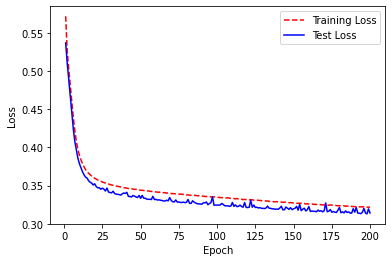

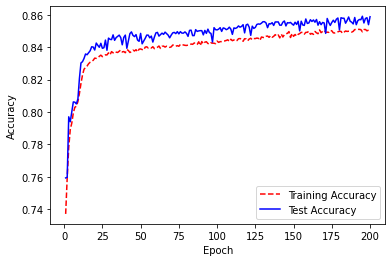

In [15]:
h_callback = model.fit(X_train, y_train, epochs = 200,validation_data=(X_test, y_test))


training_loss = h_callback.history['loss']
test_loss = h_callback.history['val_loss']
training_acc = h_callback.history['accuracy']
test_acc = h_callback.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### c. BONUS: implement an early stopping criterion using callbacks

In [16]:
from keras.callbacks import EarlyStopping
model.fit(X_train, y_train, epochs=100,verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=1)])

# E. Testing (3 pts)
### a. Based on the validation error, which model is the best?

In [17]:
from sklearn.metrics import accuracy_score
y_pred_neural = model.predict(X_test)
y_pred_logistic = LR.predict(X_test)
y_pred_tree = dt.predict(X_test)

print('{:s} : {:.3f}'.format('Decision Tree: ', accuracy_score(y_test, y_pred_tree)))
print('{:s} : {:.3f}'.format('Logistic Regression: ', accuracy_score(y_test, y_pred_logistic)))
print('{:s} : {:.3f}'.format('Neural Network: ', accuracy_score(y_test, y_pred_neural)))


Decision Tree:  : 0.817
Logistic Regression:  : 0.852
Neural Network:  : 0.848


LogisticRegression has the highest Accuracy so its the best model

### b. Report the performance metrics (accuracy, f-measure, precision, recall) on testing data


In [18]:
from sklearn.metrics import classification_report

predicted = LR.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4945
           1       0.74      0.60      0.66      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.78      6513
weighted avg       0.85      0.85      0.85      6513



### c. Compute the percentage of women with prediction of income >=50k in the testing set?


In [19]:
women_rich = 0
women_poor = 0
total = y_test.shape[0]
for i in range(total):
    if ((X_test.iloc[i]["Gender_ Female"]==1) and predicted[i]==1):
        women_rich+=1
    elif ((X_test.iloc[i]["Gender_ Female"]==1) and predicted[i]==0):
        women_poor+=1

print("percentage of women predicted with an income >=50k versus women with an income of <=50k:", (women_rich/(women_rich+women_poor))*100, "%")

percentage of women predicted with an income >=50k versus women with an income of <=50k: 6.592386258124419 %


### d. Compute the percentage of men with prediction of income >=50k in the testing set?


In [20]:
men_rich = 0
men_poor = 0
total = y_test.shape[0]
for i in range(total):
    if ((X_test.iloc[i]["Gender_ Male"]==1) and predicted[i]==1):
        men_rich+=1
    elif ((X_test.iloc[i]["Gender_ Male"]==1) and predicted[i]==0):
        men_poor+=1

print("percentage of men predicted with an income >=50k versus men with an income of <=50k:", (men_rich/(men_rich+men_poor))*100, "%")

percentage of men predicted with an income >=50k versus men with an income of <=50k: 25.8086717136958 %


### e. Comment on the fairness of your model 

In [21]:
men_rich_Cuba = 0
men_poor_Cuba = 0
total = y_test.shape[0]
for i in range(total):
    if ((X_test.iloc[i]["Gender_ Male"]==1) and (X_test.iloc[i]["Native Country_ Cuba"]==1) and predicted[i]==1):
        men_rich_Cuba+=1
    elif ((X_test.iloc[i]["Gender_ Male"]==1) and (X_test.iloc[i]["Native Country_ Cuba"]==1) and predicted[i]==0):
        men_poor_Cuba+=1

print("percentage of men predicted with an income >=50k versus men with an income of <=50k(in Cuba):", (men_rich_Cuba/(men_rich_Cuba+men_poor_Cuba))*100, "%")

men_rich_USA = 0
men_poor_USA = 0
total = y_test.shape[0]
for i in range(total):
    if ((X_test.iloc[i]["Gender_ Male"]==1) and (X_test.iloc[i]["Native Country_ United-States"]==1) and predicted[i]==1):
        men_rich_USA+=1
    elif ((X_test.iloc[i]["Gender_ Male"]==1) and (X_test.iloc[i]["Native Country_ United-States"]==1) and predicted[i]==0):
        men_poor_USA+=1

print("percentage of men predicted with an income >=50k versus men with an income of <=50k(in USA):", (men_rich_USA/(men_rich_USA+men_poor_USA))*100, "%")

percentage of men predicted with an income >=50k versus men with an income of <=50k(in Cuba): 14.285714285714285 %
percentage of men predicted with an income >=50k versus men with an income of <=50k(in USA): 26.107634543178975 %


The Result obtained above shows that men in USA tend to be poorer than men in Cuba. However, we know that this is not true and this is an example of bias in the dataset we are given. That being said, our model correctly predicted the income of the instance that we are given in the dataset, meaning that the model itself is fair. However, the dataset is not.